# Post Processing

This notebook is used to post process submissions. It's divided into 5 majors steps :
1. Extract automatically all archives from the input directory.
2. Convert all denses point cloud files (`.las` or `.laz`) into DEMs with `point2dem` command from ASP.
3. Coregister DEMs with references DEMs. And compute difference between coregistered DEMs and references DEMs.
4. Compute some global statistics on all the Post Processing.
5. Generate some plots.


In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
import history
import history.postprocessing.visualization as viz
from pathlib import Path
import pandas as pd
import numpy as np

## Settings and Paths Managing

For the post Preprocessing workflow their is a lot of directory and paths. To simplify it, let's used the class `history.postprocessing.PathsManager`. 

In [3]:
BASE_DIR = Path("/mnt/summer/USERS/DEHECQA/history/output") 

CUSTOM_PATHS = {
    "processing_dir": BASE_DIR / "test_data",
    "raw_dems_dir": BASE_DIR / "test_data" / "dems",
    "coreg_dems_dir": BASE_DIR / "test_data" / "coregistered_dems",
    "casagrande_ref_dem_zoom": BASE_DIR / "test_data" / "ref_lowres_dems" / "casa_grande_reference_dem_zoom_30m.tif",
    "casagrande_ref_dem_large": Path("/mnt/summer/USERS/DEHECQA/history/data_final") / "casa_grande" / "aux_data" / "reference_dem_large.tif",
    "iceland_ref_dem_zoom": BASE_DIR / "test_data" / "ref_lowres_dems" / "iceland_reference_dem_zoom_30m.tif",
    "iceland_ref_dem_large": Path("/mnt/summer/USERS/DEHECQA/history/data_final") / "iceland" / "aux_data" / "reference_dem_large.tif",
}
paths_manager = history.postprocessing.PathsManager(BASE_DIR, CUSTOM_PATHS)

# other settings
OVERWRITE = False
DRY_RUN = False # set this to True to avoid process
MAX_WORKERS = 4
VERBOSE = True

postproc = history.postprocessing.PostProcessing(paths_manager)

## Step 1 : extract submissions

In [4]:
postproc.uncompress_all_submissions(OVERWRITE, DRY_RUN, VERBOSE)

Found 27 archive files
/mnt/summer/USERS/DEHECQA/history/output/raw/ASPY_CG.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/ASPY_IL.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/ESM_project_HISTORY_submission.zip
/mnt/summer/USERS/DEHECQA/history/output/raw/HIATUS_CG_AI_PP_CY_GY_PN_MN.zip
/mnt/summer/USERS/DEHECQA/history/output/raw/HIATUS_CG_AI_PP_CY_GY_PN_MY.zip
/mnt/summer/USERS/DEHECQA/history/output/raw/HSfM_CG_AI_PP_CY_GN_PY_MN.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/HSfM_CG_AI_PP_CY_GY_PY_MN.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/HSfM_IL_AI_PP_CY_GN_PY_MN.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/HSfM_IL_AI_PP_CY_GY_PN_MN.tgz
/mnt/summer/USERS/DEHECQA/history/output/raw/JB_CG_AI_PP_CY_GN_PN_MN.tar.gz
/mnt/summer/USERS/DEHECQA/history/output/raw/JB_CG_MC_PP_CY_GN_PN_MN.tar.gz
/mnt/summer/USERS/DEHECQA/history/output/raw/JB_IL_AI_PP_CY_GN_PN_MN.tar.gz
/mnt/summer/USERS/DEHECQA/history/output/raw/JB_IL_MC_PP_CY_GN_PN_MN.tar.gz
/mnt/summer/USERS/DEHECQA

{'ASPY_CG.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/ASPY_CG',
 'ASPY_IL.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/ASPY_IL',
 'ESM_project_HISTORY_submission.zip': '/mnt/summer/USERS/DEHECQA/history/output/extracted/ESM_project_HISTORY_submission',
 'HIATUS_CG_AI_PP_CY_GY_PN_MN.zip': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HIATUS_CG_AI_PP_CY_GY_PN_MN',
 'HIATUS_CG_AI_PP_CY_GY_PN_MY.zip': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HIATUS_CG_AI_PP_CY_GY_PN_MY',
 'HSfM_CG_AI_PP_CY_GN_PY_MN.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HSfM_CG_AI_PP_CY_GN_PY_MN',
 'HSfM_CG_AI_PP_CY_GY_PY_MN.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HSfM_CG_AI_PP_CY_GY_PY_MN',
 'HSfM_IL_AI_PP_CY_GN_PY_MN.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HSfM_IL_AI_PP_CY_GN_PY_MN',
 'HSfM_IL_AI_PP_CY_GY_PN_MN.tgz': '/mnt/summer/USERS/DEHECQA/history/output/extracted/HSfM_IL_AI_PP_CY_GY_PN_MN',
 'JB_CG_AI_PP_CY_GN_PN_MN.ta

## Visualize Post Processing files

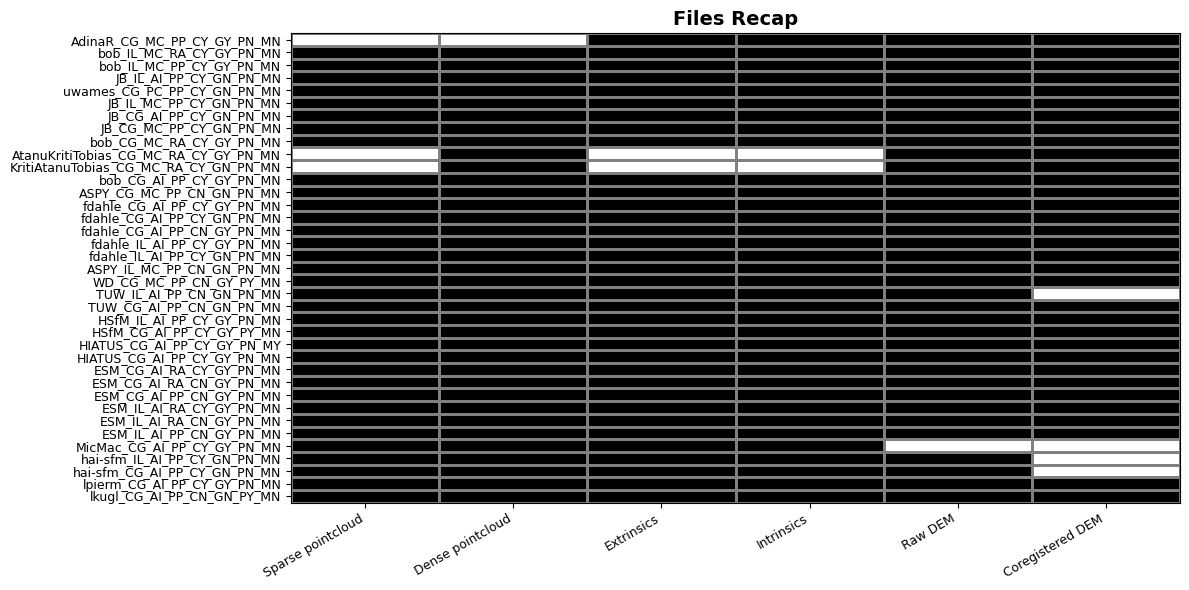

In [8]:
postproc.plot_files_recap()

## Step 2: Convert Dense Point Cloud Files into DEMs

This step processes **dense point cloud files** to generate DEMs that are spatially aligned with their corresponding reference DEMs.

- **Input search**: Point cloud files are searched **recursively** in the directory `extracted_submissions_dir` using the pattern `*_dense_pointcloud.{las,laz}`.  
- **Output location**: The resulting DEMs are saved in the directory `raw_dems_dir`.  
- **Reference selection**: For each point cloud file, the appropriate reference DEM is selected based on its `site` and `dataset` metadata.  

**Note:**  
The method `iter_point2dem` launches the ASP `point2dem` command with the parameters:  
- `max_concurrent_commands`: Maximum number of parallel `point2dem` processes.  
- `max_threads_per_command`: Maximum number of threads allocated to each individual process.  


In [9]:
asp_path = None
max_concurrent_commands = 1

postproc.iter_point2dem(OVERWRITE, DRY_RUN, asp_path, max_concurrent_commands, max_threads_per_command=MAX_WORKERS)

Skip lkugl_CG_AI_PP_CN_GN_PY_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/lkugl_CG_AI_PP_CN_GN_PY_MN-DEM.tif already exist.
Skip lkugl_CG_AI_PP_CN_GN_PY_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/lkugl_CG_AI_PP_CN_GN_PY_MN-DEM.tif already exist.
Skip lkugl_CG_AI_PP_CN_GN_PY_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/lkugl_CG_AI_PP_CN_GN_PY_MN-DEM.tif already exist.
Skip lpierm_CG_AI_PP_CY_GY_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/lpierm_CG_AI_PP_CY_GY_PN_MN-DEM.tif already exist.
Skip hai-sfm_CG_AI_PP_CY_GN_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/hai-sfm_CG_AI_PP_CY_GN_PN_MN-DEM.tif already exist.
Skip hai-sfm_CG_AI_PP_CY_GN_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/hai-sfm_CG_AI_PP_CY_GN_PN_MN-DEM.tif already exist.
Skip hai-sfm_IL_AI_PP_CY_GN_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/dems/hai-sfm_IL_AI_PP_CY_GN_PN_MN-DEM.tif already exist.
Skip E

### Clean up the RAW_DEM_DIRECTORY
Simply move log files into a folder and eventually remove temporary files

In [11]:
!mkdir -p {RAW_DEM_DIRECTORY}/log
!mv {RAW_DEM_DIRECTORY}/*-log-point2dem-*.txt {RAW_DEM_DIRECTORY}/log 2>/dev/null || true
!rm -f {RAW_DEM_DIRECTORY}/*-tmp-*.tif

## Step 3: Coregister DEMs

Coregister multiple DEMs in a directory to appropriate reference DEMs and return summary statistics.

This function iterates over all DEM files in `input_directory` ending with '-DEM.tif', 
selects the appropriate reference DEM and mask based on the site and dataset information,
and applies coregistration using the `coregister_dem` function. 

Coregistered DEMs are saved to `output_directory`. If `overwrite` is False, existing output files are skipped.
If `dry_run` is True, no coregistration is performed, only file names and planned operations are printed.

In [12]:
postproc.iter_coregister_dems(OVERWRITE, DRY_RUN, VERBOSE)

Skip AdinaR_CG_MC_PP_CY_GY_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/AdinaR_CG_MC_PP_CY_GY_PN_MN-DEM_coreg.tif already exist.
Skip ESM_IL_AI_RA_CN_GY_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ESM_IL_AI_RA_CN_GY_PN_MN-DEM_coreg.tif already exist.
Skip HSfM_IL_AI_PP_CY_GY_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/HSfM_IL_AI_PP_CY_GY_PN_MN-DEM_coreg.tif already exist.
Skip ESM_CG_AI_PP_CN_GY_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ESM_CG_AI_PP_CN_GY_PN_MN-DEM_coreg.tif already exist.
Skip ASPY_CG_MC_PP_CN_GN_PN_MN : /mnt/summer/USERS/DEHECQA/history/output/test_data/coregistered_dems/ASPY_CG_MC_PP_CN_GN_PN_MN-DEM_coreg.tif already exist.
coregister_dem(/mnt/summer/USERS/DEHECQA/history/output/test_data/dems/TUW_IL_AI_PP_CN_GN_PN_MN-DEM.tif, /mnt/summer/USERS/DEHECQA/history/output/test_data/ref_lowres_dems/iceland_reference_dem_zoom_30m.tif, /mnt/su

## Step 4: Compute statistics

In [17]:
postproc.compute_global_df()

## Step 5 : Generate some plots



In [18]:
df = postproc.get_global_df()
plot_dir = BASE_DIR / "test_data" / "plots"

# print some informations about the global df
participant_number = len(df["author"].unique())
submission_number = len(df)

print(f"Number of participants : {participant_number}")
print(f"Number of submissions : {submission_number}")

print("submission by site/dataset :\n")
print(pd.crosstab(df["dataset"], df["site"]))

Number of participants : 17
Number of submissions : 37
submission by site/dataset :

site     casa_grande  iceland
dataset                      
aerial            16        9
kh9mc              7        4
kh9pc              1        0


generate all statistics plots

In [16]:
stat_dir = plot_dir / "statistics"
viz.generate_nmad_groupby(df, stat_dir / "nmad")
viz.barplot_var(df, stat_dir, "dense_point_count", "Point count")
viz.barplot_var(df, stat_dir, "nmad_before_coreg", "NMAD before coregistration")
viz.plot_coregistration_shifts(df, stat_dir / "coreg_shifts")

generate individual coregistration plots

In [19]:
viz.generate_coregistration_individual_plots(df, plot_dir / "coregistration_individual_plots")

Generating coregistration plots:  21%|████████████████                                                            | 7/33 [00:21<00:52,  2.02s/it]/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
Generating coregistration plots: 100%|███████████████████████████████████████████████████████████████████████████| 33/33 [01:17<00:00,  2.35s/it]


generate std dems 

In [ ]:
viz.generate_std_dems_by_dataset_site(df, plot_dir / "std_dems")

generate all mosaic plots (can take a while)

In [ ]:
max_cols = {
    ("aerial", "casa_grande"): 5,
    ("aerial", "iceland"): 4,
    ("kh9mc", "casa_gande"): 4,
    ("kh9mc", "iceland"): 4,
    ("kh9pc", "casa_grande"): 4,
    ("kh9pc", "iceland"): 4,
}

viz.generate_dems_mosaic(df, plot_dir / "mosaic-DEMs", max_cols)
viz.generate_ddems_mosaic(df, plot_dir / "mosaic-DDEMs", max_cols)
viz.generate_hillshades_mosaic(df, plot_dir / "mosaic-hillshades", max_cols)
viz.generate_slopes_mosaic(df, plot_dir / "mosaic-slopes", max_cols)

In [6]:
outliers_code = [
    "fdahle_CG_AI_PP_CN_GY_PN_MN",
    "fdahle_CG_AI_PP_CY_GN_PN_MN",
    "fdahle_IL_AI_PP_CY_GN_PN_MN",
]

df_without_outliers = df.drop(index=outliers_code)

## Plotting some general statistics without outliers

To remove outliers we will look at the nmad_after_coreg and remove all lines which are to high.

In [20]:
k = 4

df = postproc.get_global_df().dropna(subset="nmad_before_coreg").copy()

# --- compute median and MAD per group (aligned to original index) ---
median = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform("median")
mad = df.groupby(["dataset", "site"])["nmad_after_coreg"].transform(lambda x: np.median(np.abs(x - np.median(x))))

# normalize MAD to be comparable to std (for normal dist: sigma ≈ MAD * 1.4826)
normalized_mad = mad * 1.4826

# filter outliers above the threshold
mask =  df["nmad_after_coreg"] <= median + k * normalized_mad

df["is_outlier"] = ~mask

df.loc[df["is_outlier"]]

,author,site,dataset,images,camera_used,gcp_used,pointcloud_coregistration,mtp_adjustment,dense_pointcloud_file,sparse_pointcloud_file,...,coreg_shift_x,coreg_shift_y,coreg_shift_z,mean_before_coreg,median_before_coreg,nmad_before_coreg,mean_after_coreg,median_after_coreg,nmad_after_coreg,is_outlier
code,,,,,,,,,,,,,,,,,,,,,
fdahle_CG_AI_PP_CN_GY_PN_MN,fdahle,casa_grande,aerial,preprocessed,False,True,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/extra...,...,-1494.661626,457.998316,0.756195,-1.710645,-3.173859,7.678138,1.556604,0.000000,7.879095,True
fdahle_CG_AI_PP_CY_GN_PN_MN,fdahle,casa_grande,aerial,preprocessed,True,False,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/extra...,...,10141.567582,1293.896290,577.203125,-559.596070,-569.558350,43.412743,0.857168,0.000015,71.029430,True
fdahle_IL_AI_PP_CY_GN_PN_MN,fdahle,iceland,aerial,preprocessed,True,False,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/extra...,...,147.126380,-21.562636,4.782547,-0.962673,-6.486496,23.830980,5.010852,0.000000,25.376675,True
fdahle_IL_AI_PP_CY_GY_PN_MN,fdahle,iceland,aerial,preprocessed,True,True,False,False,/mnt/summer/USERS/DEHECQA/history/output/extra...,/mnt/summer/USERS/DEHECQA/history/output/extra...,...,10.172176,-3.338206,0.522545,-1.773083,-0.618774,4.942399,-1.132904,0.000008,5.075161,True
